## Загрузка данных

In [1]:
# импорт модулей
import pandas as pd
import numpy as np
from math import ceil

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split

from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
import torch
from torch import nn

from sklearn.metrics import mean_squared_error

np.random.seed(42)

In [2]:
df = pd.read_csv('/datasets/6_class.csv', index_col=0)

## Предобработка и анализ данных

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 240 entries, 0 to 239
Data columns (total 6 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Temperature (K)         240 non-null    int64  
 1   Luminosity(L/Lo)        240 non-null    float64
 2   Radius(R/Ro)            240 non-null    float64
 3   Absolute magnitude(Mv)  240 non-null    float64
 4   Star type               240 non-null    int64  
 5   Star color              240 non-null    object 
dtypes: float64(3), int64(2), object(1)
memory usage: 13.1+ KB


In [4]:
df.columns = ['temperature', 'luminosity', 'radius', 'absolute_magnitude', 'star_type', 'star_color']

### Категориальные данные:

In [5]:
# сначала изучим данные о цветах звёзд.
colors_data = df.groupby('star_color').agg({'star_color': 'count'}).T
display(colors_data)
print('Всего классов:', colors_data.shape[1])

star_color,Blue,Blue,Blue White,Blue white,Blue white,Blue-White,Blue-white,Orange,Orange-Red,Pale yellow orange,Red,White,White-Yellow,Whitish,Yellowish,Yellowish White,white,yellow-white,yellowish
star_color,55,1,10,3,1,1,26,2,1,1,112,7,1,2,1,3,3,8,2


Всего классов: 19


*В данных много неявных дубликатов. Испарвим это.*

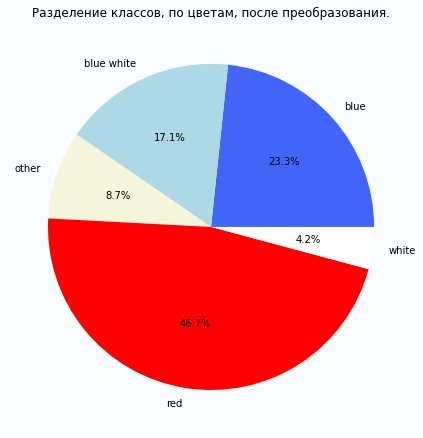

In [6]:
# преобразуем значения данных и избавимся от явных/неявных дубликатов
df['star_color'] = [v.lower().replace('-', ' ').strip() for v in df['star_color']] 
df['star_color'] = df['star_color'].replace({'white yellow': 'other',
                         'orange red': 'other',
                         'whitish': 'other',
                         'pale yellow orange': 'other',
                         'orange': 'other',
                         'yellow white': 'other',
                         'yellowish': 'other',
                         'yellowish white': 'other',
                         'yellow white': 'other'})


# заново инциаилизируем объект, уже после предобработки
colors_data = df.groupby('star_color')['star_color'].agg('count')

fig = plt.figure(figsize=(7.5, 7.5))
fig.patch.set_facecolor('#fafdff')

plt.pie(colors_data.values,
        labels=colors_data.index,
        autopct='%1.1f%%',
        colors=['#4065f7', 'lightblue', 'beige', 'red', 'white'])
plt.title('Разделение классов, по цветам, после преобразования.')
plt.show()

**Вместо 19 классов, получили 5. Так моделе будет гораздо проще работать с данными.**

In [7]:
df.groupby('star_type')['star_type'].agg('count')

star_type
0    40
1    40
2    40
3    40
4    40
5    40
Name: star_type, dtype: int64

**Во втором категориальном признаке star_type - наблюдается идеальный баланс классов.**

### Количественные данные:

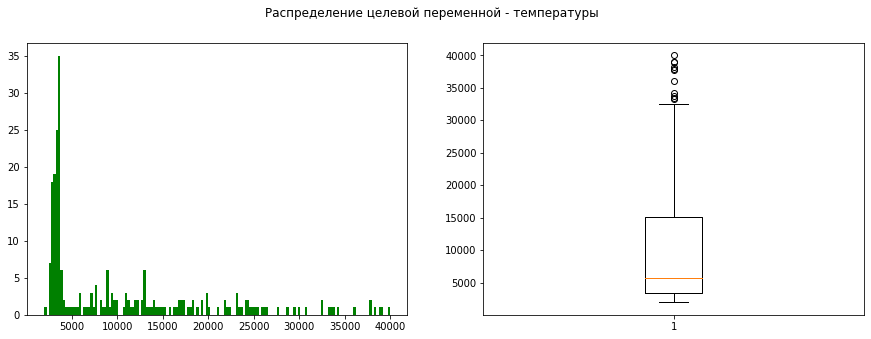

In [8]:
# в первую очередь изучим целевую переменную
fig, (ax1, ax2) = plt.subplots(1, 2)
fig.set_figheight(5)
fig.set_figwidth(15)
ax1.hist(df['temperature'].values, color='green', bins=150)
ax2.boxplot(df['temperature'])
fig.suptitle('Распределение целевой переменной - температуры')
plt.show()

Целевая переменная распределана не нормально. Требуется дополнительное изучение:

    1) исследуем количество выбросов;
    2) подробно посмотрим причину их появления;
    3) определим какое влияение они оказывают на данные;
    4) решим, оставить выбросы или же избавиться от них.

In [9]:
max_temp_potential = df['temperature'].quantile(0.75) * 1.5      # определим макисмально допустимый предел выбросов;
statistical_outlier = df[df['temperature'] > max_temp_potential] # инциализируем датафрейм с выбросами
statistical_outlier

,temperature,luminosity,radius,absolute_magnitude,star_type,star_color
20,25000,0.05600,0.0084,10.580,2,blue white
30,39000,204000.00000,10.6000,-4.700,3,blue
31,30000,28840.00000,6.3000,-4.200,3,blue white
49,33750,220000.00000,26.0000,-6.100,4,blue
99,36108,198000.00000,10.2000,-4.400,3,blue
100,33300,240000.00000,12.0000,-6.500,4,blue
101,40000,813000.00000,14.0000,-6.230,4,blue
102,23000,127000.00000,36.0000,-5.760,4,blue
106,24630,363000.00000,63.0000,-5.830,4,blue
108,24345,142000.00000,57.0000,-6.240,4,blue


*Выбросам по верхнему пределу в основном характеризиуются звёзды с очень высокой яркостью, что весьма логично. Также, в основном - это голубые или бело-голубые планеты.
В данном случае, выбросы, точно не являются ошибкой. Видна закономерность, в каком случае, температура выше заявленного. Это приемлемо.*

In [10]:
# изучим данные без выбросов
df_good = df[~df.index.isin(statistical_outlier.index)].describe()

print('Данные без потенциальных выбросов:')
display(df_good)

print('\nДанные с выбросами:')
display(df.describe())

Данные без потенциальных выбросов:


,temperature,luminosity,radius,absolute_magnitude,star_type
count,206.000000,206.000000,206.000000,206.000000,206.000000
mean,7345.004854,79884.362783,209.113685,5.911383,2.286408
std,5542.115279,153720.943496,485.858509,10.409810,1.716636
min,1939.000000,0.000080,0.008700,-11.920000,0.000000
25%,3276.250000,0.000713,0.097375,-6.072500,1.000000
50%,3655.000000,0.005450,0.377050,11.340000,2.000000
75%,10995.000000,129750.000000,25.000000,14.222500,4.000000
max,22350.000000,783930.000000,1779.000000,20.060000,5.000000



Данные с выбросами:


,temperature,luminosity,radius,absolute_magnitude,star_type
count,240.000000,240.000000,240.000000,240.000000,240.000000
mean,10497.462500,107188.361635,237.157781,4.382396,2.500000
std,9552.425037,179432.244940,517.155763,10.532512,1.711394
min,1939.000000,0.000080,0.008400,-11.920000,0.000000
25%,3344.250000,0.000865,0.102750,-6.232500,1.000000
50%,5776.000000,0.070500,0.762500,8.313000,2.500000
75%,15055.500000,198050.000000,42.750000,13.697500,4.000000
max,40000.000000,849420.000000,1948.500000,20.060000,5.000000


**На мой взгляд ситуация меняется не так значительно, чтобы прибегать к снижению количества данных. Скорей всего при отказа от части данных результаты обучения ухудашться.**

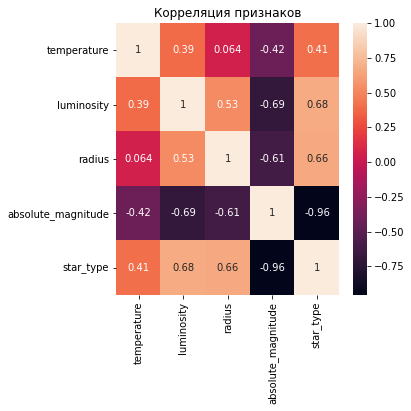

In [11]:
# теперь изучим корреляцию признаков
corr = df.corr()

plt.figure(figsize=(5, 5))
sns.heatmap(corr,
            annot=True)
plt.title('Корреляция признаков')
plt.show()

*В наименьшей мере на целевую переменную влияет признак "Radius(R/Ro)" радиус звезды относительно радиуса Солнца. Я бы заменил этот признак, на категориальный. Разделив планеты на условно маленькие (меньше 0.25 квантиля], средние (от 0.25 до 0.5], большие (от 0.5 до 0.75] и ультра (>0.75).*

In [12]:
low_filter = df['radius'].quantile(0.25)
median_filter = df['radius'].quantile(0.5)

def to_object(x, low_filter=low_filter, median_filter=median_filter):
    '''
    Функция предназначена для категоризации числовых объектов в признаке radius.
    '''
    if x <= low_filter:
        return 'small'
    elif x <= median_filter:
        return 'mean'
    else:
        return 'big'

df['radius'] = df['radius'].apply(lambda x: to_object(x))

In [13]:
df.groupby('radius')['radius'].agg('count') 

radius
big      120
mean      60
small     60
Name: radius, dtype: int64

**Получилось достичь идеального баланса классов**

### Предобработка данных

In [14]:
# теперь разделим данные
train, test = train_test_split(df, train_size=0.9, random_state=42)

In [15]:
numeric_features = ['temperature', 'luminosity', 'absolute_magnitude']
categorical_features = ['radius', 'star_type', 'star_color']

col_transformer = ColumnTransformer(
                            transformers=[
                                ('scaler', StandardScaler(), numeric_features),
                                ('ohe', OneHotEncoder(sparse=False, drop='first'), categorical_features)],
                                    remainder="passthrough"
                                      )

X_train = pd.DataFrame(col_transformer.fit_transform(train))
X_test = pd.DataFrame(col_transformer.transform(test))

In [16]:
std_ = train['temperature'].std()
mean_ = train['temperature'].mean()

In [17]:
y_train = torch.Tensor(X_train[0].values)
y_test = torch.Tensor(X_test[0].values)

X_train = torch.Tensor(X_train.drop(columns=0).values)
X_test = torch.Tensor(X_test.drop(columns=0).values)

## Построение базовой нейронной сети

In [18]:
learning_rate = 0.01
batch_size = 100
num_epochs = 2000
num_batches = ceil(len(X_train) / batch_size)

class Net(nn.Module):
    def __init__(self, in_neurons, n_hidden_neurons_1, n_hidden_neurons_2, n_out_neurons):
        super(Net, self).__init__()  
        self.fc1 = nn.Linear(in_neurons, n_hidden_neurons_1)
        self.fc2 = nn.Linear(n_hidden_neurons_1, n_hidden_neurons_2)
        self.fc3 = nn.Linear(n_hidden_neurons_2, n_out_neurons)
        self.relu = nn.ReLU()
        self.flatten = nn.Flatten(start_dim=0)
        
    def forward(self, x):
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        x = self.relu(x)
        x = self.fc3(x)
        return self.flatten(x)

net = Net(13, 8, 4, 1)

loss = nn.MSELoss()
optimizer = torch.optim.Adam(net.parameters(), lr=learning_rate)

patience = 5
best_rmse = float('inf')
counter = 0
rmse_results = []

for epoch in range(num_epochs):
    order = np.random.permutation(len(X_train))
    epoch_rmse = 0.0  # Инициализация RMSE для данной эпохи
    for batch_idx in range(num_batches):
        start_index = batch_idx * batch_size

        optimizer.zero_grad()
        batch_indexes = order[start_index:start_index + batch_size]
        X_batch = X_train[batch_indexes]
        y_batch = y_train[batch_indexes]

        preds = net.forward(X_batch).flatten()

        loss_value = loss(preds, y_batch)
        
        loss_value.backward()

        optimizer.step()

        epoch_rmse += loss_value.item() * len(X_batch)

    epoch_rmse = np.sqrt(epoch_rmse / len(X_train))
    rmse_results.append(epoch_rmse)

    if epoch % 100 == 0 or epoch == num_epochs - 1:
        with torch.no_grad():
            net.eval()
            preds = net.forward(X_test)
            preds = preds * std_ + mean_
            y_test_inv = y_test * std_ + mean_
            rmse = np.sqrt(mean_squared_error(preds, y_test_inv))

            if rmse < best_rmse:
                best_rmse = rmse
                counter = 0
            else:
                counter += 1

            if counter >= patience or epoch == num_epochs - 1:
                print(f'Обучение законечно на {epoch} эпохе')
                print(f'Финальная метрика качества - {best_rmse}')
                break

            net.train()


Обучение законечно на 600 эпохе
Финальная метрика качества - 4384.53125


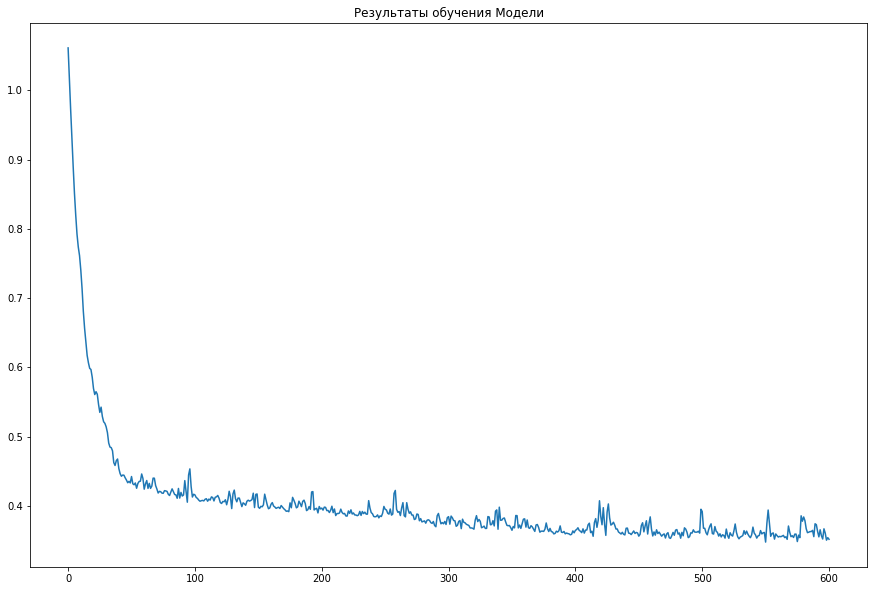

Резюмирующее качество модели составило 4384.53125


In [19]:
plt.figure(figsize=(15, 10))

plt.plot(rmse_results)

plt.title('Результаты обучения Модели')
plt.show()

print(f'Резюмирующее качество модели составило {best_rmse}')

## Улучшение нейронной сети

In [20]:
learning_rate = 0.01
batch_size = 100
num_batches = ceil(len(X_train) / batch_size)

class Net(nn.Module):
    def __init__(self, in_neurons, n_hidden_neurons_1, n_hidden_neurons_2, n_out_neurons):
        super(Net, self).__init__()  
        self.fc1 = nn.Linear(in_neurons, n_hidden_neurons_1)
        self.fc2 = nn.Linear(n_hidden_neurons_1, n_hidden_neurons_2)
        self.fc3 = nn.Linear(n_hidden_neurons_2, n_out_neurons)
        self.relu = nn.ReLU()
        self.dp = nn.Dropout(p=0.2)
        self.flatten = nn.Flatten(start_dim=0)
        
    def forward(self, x):
        x = self.fc1(x)
        x = self.relu(x)
        x = self.dp(x)
        x = self.fc2(x)
        x = self.relu(x)
        x = self.fc3(x)
        return self.flatten(x)

net = Net(13, 8, 4, 1)

loss = nn.MSELoss()
optimizer = torch.optim.Adam(net.parameters(), lr=learning_rate)


for epoch in range(epoch):
    order = np.random.permutation(len(X_train))
    epoch_rmse = 0.0  # Инициализация RMSE для данной эпохи
    for batch_idx in range(num_batches):
        start_index = batch_idx * batch_size

        optimizer.zero_grad()
        batch_indexes = order[start_index:start_index + batch_size]
        X_batch = X_train[batch_indexes]
        y_batch = y_train[batch_indexes]

        preds = net.forward(X_batch).flatten()

        loss_value = loss(preds, y_batch)
        
        loss_value.backward()

        optimizer.step()

        epoch_rmse += loss_value.item() * len(X_batch)

    epoch_rmse = np.sqrt(epoch_rmse / len(X_train))
    rmse_results.append(epoch_rmse)

    if epoch % 10 == 0 or epoch == num_epochs - 1:
        with torch.no_grad():
            net.eval()
            preds = net.forward(X_test)
            preds = preds * std_ + mean_
            y_test_inv = y_test * std_ + mean_
            rmse = np.sqrt(mean_squared_error(preds, y_test_inv))
            print(rmse)
            if rmse < best_rmse:
                break
            

12712.03
9142.413
6717.385
6287.88
5180.3545
5010.5845
4636.3403
4951.025
5196.9097
4706.859
4319.3


## Выводы

Проект состоял из 3 частей:
    
    1) Предобработка данных и EDA;
    2) Обработка данных, подготовка данных к передаче в нейросеть;
    3) Создание нейросети и её улучшение.
    
В результате выполнения проекта, были достигнуты поставленные задачи, снизу можно видеть график, визуализации результата.

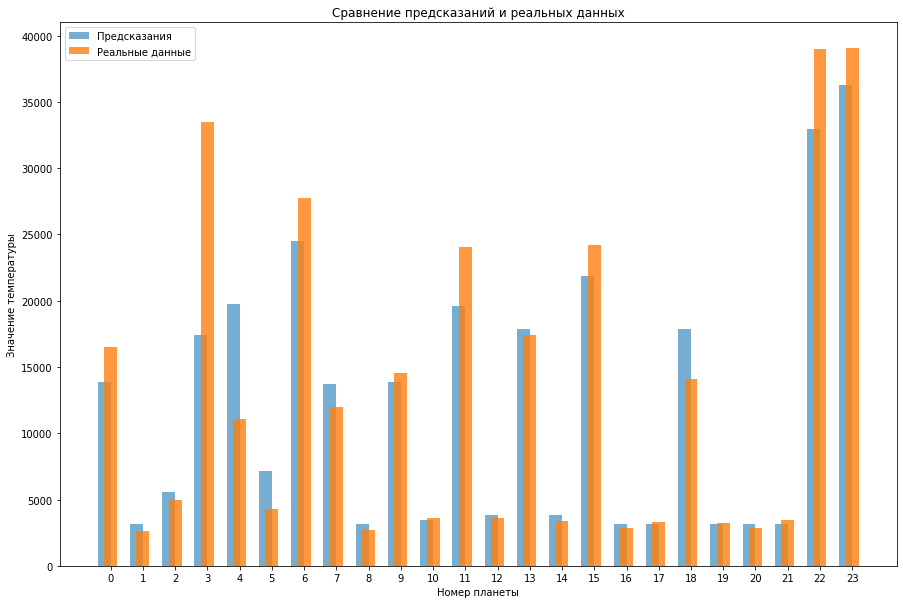

In [28]:
plt.figure(figsize=(15, 10))

# Создаем массив индексов для оси x
x_indices = np.arange(len(preds))

# Ширина столбцов
bar_width = 0.4

# Строим barplot для preds с прозрачностью 0.6
plt.bar(x_indices, preds, width=bar_width, align='center', label='Предсказания', alpha=0.6)

# Строим barplot для y_test_inv с прозрачностью 0.8 и смещением вправо
plt.bar(x_indices, y_test_inv, width=bar_width, align='edge', label='Реальные данные', alpha=0.8)

# Настройка осей и меток
plt.xlabel('Номер планеты')
plt.ylabel('Значение температуры')
plt.title('Сравнение предсказаний и реальных данных')
plt.xticks(x_indices + bar_width/2, x_indices)
plt.legend()

plt.show()